In [1]:
#행렬 처리, 이미지 파일관리 모듈
import numpy 
import scipy.special 
import scipy.misc
import matplotlib.pyplot
%matplotlib inline

In [2]:
#png 이미지 파일 부르는 모듈
import imageio
#다수의 파일을 부르는 모듈
import glob

In [3]:
#신경망 클래스
class neuralNetwork:
    
    #신경망 초기화
    def __init__(self,inputnodes,hiddennodes,outputnodes,learningrate):
        #입력,은닉,출력 계층의 노드 개수,학습률 설정
        self.inodes=inputnodes
        self.hnodes=hiddennodes
        self.onodes=outputnodes
       
        #가중치 행렬 wih와 who
        #배열 내 가중치는 w_i_j로 표기, 노드 i에서 다음 계층의 노드 j로 연결됨을 의미
        #w11 w21
        #w12 w22 등
        #wih 는 input에서 hidden으로, ho는 hidden에서 out으로
        self.wih = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        #학습률
        self.lr=learningrate
        
        #활성화 함수로는 시그모이드 함수를 이용 - lambda를 이용해 def를 대신함
        self.activation_function = lambda x: scipy.special.expit(x)
        
    def train(self, inputs_list, targets_list):
        #입력 리스트를 2차원 행렬로 변환
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        #은닉 계층으로 들어오는 신호 계산
        hidden_inputs = numpy.dot(self.wih, inputs)
        #은닉 계층에서 나가는 신호를 계산 - 시그모이드 함수에 넣음
        hidden_outputs = self.activation_function(hidden_inputs)
        
        #최종 출력 계층으로 들어오는 신호를 계산
        final_inputs = numpy.dot(self.who, hidden_outputs)
        #최종 출력 계층에서 나가는 신호를 계산 - 시그모이드 함수에 넣음
        final_outputs = self.activation_function(final_inputs)
        
        #출력 계층의 오차는 (실제 값 - 계산 값)
        output_errors = targets - final_outputs
        #은닉 계층의 오차는 가중치에 의해 나뉜 출력 계층의 오차들을 재조합해 계산
        hidden_errors = numpy.dot(self.who.T,output_errors)
        
        #은닉 계층과 출력 계층 간의 가중치 업데이트(who)
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0-final_outputs)), numpy.transpose(hidden_outputs))
        
        #입력 계층과 은닉 계층 간의 가중치 업데이트(wih)
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0-hidden_outputs)), numpy.transpose(inputs))
        
    def query(self, inputs_list):
        #입력 리스트를 2차원 행렬로 변환
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        #은닉 계층으로 들어오는 신호를 계산 - wih와 inputs 행렬을 곱함
        hidden_inputs = numpy.dot(self.wih, inputs)
        #은닉 계층에서 나가는 신호를 계산 - 시그모이드 함수에 넣음
        hidden_outputs = self.activation_function(hidden_inputs)
        
        #최종 출력 계층으로 들어오는 신호를 계산
        final_inputs = numpy.dot(self.who, hidden_outputs)
        #최종 출력 계층에서 나가는 신호를 계산 - 시그모이드 함수에 넣음
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs

In [4]:
#새로운 신경망 인스턴스 선언 - 그림 파일의 픽셀수 28*28=784 = 인풋 노드 수
#은닉 노드의 수 = 100개
#출력 노드의 수 = 10개 (0부터 9까지의 수 판독)
input_nodes=784
hidden_nodes=200
output_nodes=10

learning_rate =0.1
n=neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [5]:
#학습할 데이터 오픈
training_data_file = open("mnist_dataset/mnist_train.csv",'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [6]:
# 신경망 학습시키기

# 주기(epoch)란 학습 데이터가 학습을 위해 사용되는 횟수를 의미
epochs = 5

for e in range(epochs):
    # 학습 데이터 모음 내의 모든 레코드 탐색
    for record in training_data_list:
        # 레코드를 쉼표에 의해 분리하고
        all_values=record.split(',')
        # 입력 값의 범위를 학습에 알맞게 0.01~1로 조정
        inputs = (numpy.asfarray(all_values[1:])/255.0 * 0.99) + 0.01
        # 결과 값 생성 ( 실제 값인 0.99 외에는 모두 0.01)
        targets = numpy.zeros(output_nodes)+0.01
        # 첫 레코드 값이 정답인 걸 이용하여 그에 맞는 값은 0.99 대입
        targets[int(all_values[0])]=0.99
        n.train(inputs,targets)

In [18]:
# 손글씨 데이터 세트
our_own_dataset = []

# png 이미지 파일을 테스트 데이터로 불러온다
for image_file_name in glob.glob('my_own_images/2828_my_own_?.png'):
    
    #파일 이름에 확장자명 바로 앞에 있는 숫자가 답으로 설정
    label = int(image_file_name[-5:-4])
    print(image_file_name)
    #이미지 파일을 array에 넣는다
    img_array = scipy.misc.imread(image_file_name,flatten=True)
    
    #이미지 파일을 28*28 픽셀로 재구성한다
    img_data = 255.0 - img_array.reshape(784)
    
    # 그다음 값을 함수에 넣기 위해 0.01 부터 1.0으로 스케일 한다
    img_data = (img_data /255.0 *0.99)+0.01
    
    #정답을 img_data 파일에 붙힌 후 record에 할당
    #record를 학습 데이터 리스트에 붙힌다
    record = numpy.append(label,img_data)
    our_own_dataset.append(record)

my_own_images\2828_my_own_0.png
my_own_images\2828_my_own_1.png
my_own_images\2828_my_own_2.png
my_own_images\2828_my_own_3.png
my_own_images\2828_my_own_4.png
my_own_images\2828_my_own_5.png
my_own_images\2828_my_own_6.png
my_own_images\2828_my_own_7.png
my_own_images\2828_my_own_8.png
my_own_images\2828_my_own_9.png


C:\Users\Iris\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


[[0.01394282]
 [0.00173037]
 [0.30844711]
 [0.52060192]
 [0.01482706]
 [0.05521449]
 [0.04742996]
 [0.00621991]
 [0.76295229]
 [0.20206068]]
network says  8
no match!


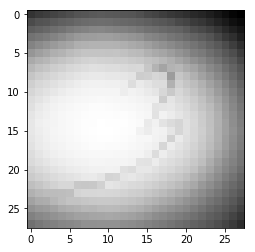

In [19]:
# 직접 쓴 손글씨를 테스트한다

# record to test
item =3

#이미지파일 출력 - 정답을 제외한 값을 28*28로 재구성한 후 출력
matplotlib.pyplot.imshow(our_own_dataset[item][1:].reshape(28,28), cmap= 'Greys', interpolation = 'None')

#정답은 첫번째 값
correct_label = our_own_dataset[item][0]
#데이터는 첫번째 값을 제외한 값
inputs = our_own_dataset[item][1:]

#신경망에게 물어보기
outputs = n.query(inputs)
print(outputs)

#가장 높은 값을 정답으로
label = numpy.argmax(outputs)
print("network says ", label)

# 정답 판단
if(label==correct_label):
    print("match!")
else:
    print("no match!")

In [15]:
#테스트 파일 열기
test_data_file=open("mnist_dataset/mnist_test.csv",'r')
test_data_list=test_data_file.readlines()
test_data_file.close()

In [16]:
# 신경망 테스트

# 신경망의 성능의 지표가 되는 성적표를 아무 값도 가지지 않도록 초기화
scorecard=[]

# 테스트 데이터 모음 내의 모든 레코드 탐색
for record in test_data_list:
    # 레코드를 쉼표에 의해 분리
    all_values=record.split(',')
    # 정답은 첫번째 값
    correct_label=int(all_values[0])
    #print(correct_label, "correct label")
    # 입력 값의 범위와 값 조정
    inputs = (numpy.asfarray(all_values[1:])/255.0 * 0.99) +0.01
    # 신경망에 질의
    outputs = n.query(inputs)
    # 가장 높은 값의 인덱스는 레이블의 인덱스와 일치
    label = numpy.argmax(outputs)
    #print(label, "network's answer")
    # 정답 또는 오답을 리스트에 추가
    if(label==correct_label):
        #정답인 경우 성적표에 1을 더함
        scorecard.append(1)
    else:
        # 정답이 아닌 경우 성적표에 0을 더함
        scorecard.append(0)

In [17]:
#정답의 비율인 성적을 계산해 출력
scorecard_array=numpy.asarray(scorecard)
print("performance = ", scorecard_array.sum()/scorecard_array.size)

performance =  0.9736
